# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from spiffyplots import MultiPanel

from stork.datasets import make_coRandman, RasDataset, split_dataset
from stork.activations import SuperSpike
from stork.regularizers import LowerBoundL2, UpperBoundL2
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DeltaSynapseLIFGroup
from stork.connections import Connection, SuperConnection
from stork.generators import StandardGenerator
from stork.initializers import KaimingNormalInitializer
from stork.monitors import SpikeCountMonitor, StateMonitor
from stork.optimizers import SMORMS3
from stork.loss_stacks import MaxOverTimeCrossEntropy
from stork.plotting import plot_activity_snapshot

## Generate Dataset

Specify the Dataset Parameters

In [2]:
dim_manifold = 1
nb_sub_classes = 3
nb_classes = nb_sub_classes**2
nb_inputs = 10

nb_time_steps = 180
T_delay = 60
sample_duration = 30


nb_samples = 300
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt

## Create delay task

In [3]:
data, labels = make_coRandman(
    dim_manifold=dim_manifold,
    nb_classes=nb_sub_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=sample_duration / nb_time_steps,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
    T_delay=T_delay + sample_duration,
)

In [4]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=False)
]
ds_train, ds_valid, ds_test = datasets

In [5]:
print(len(ds_train))

648000


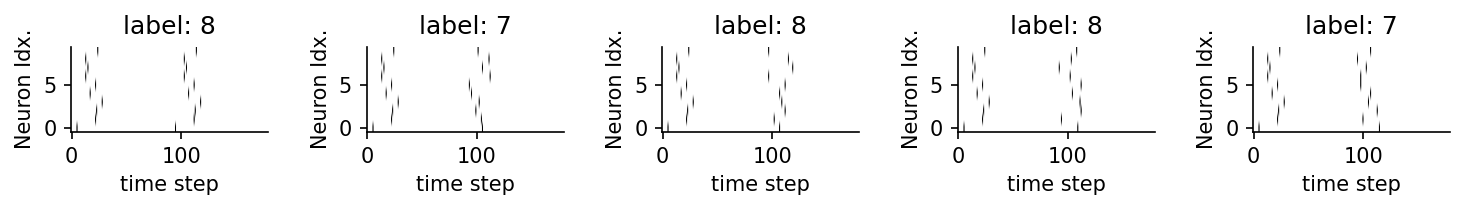

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [7]:
# Model Parameters
batch_size = 3000
beta = 20
device = torch.device("cuda:1")
dtype = torch.float


nb_hidden_units = 128
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 40e-3

tau_filter = 20e-3
nb_filters = 10

lr = 5e-3
nb_epochs = 100

In [8]:
act_fn = SuperSpike
act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [9]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    DeltaSynapseLIFGroup(
        nb_hidden_units,
        tau_mem=tau_mem,
        # tau_syn=tau_syn,
        activation=act_fn,
    )
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [10]:
con = model.add_connection(
    SuperConnection(
        input_group, hidden_neurons, tau_filter=tau_filter, nb_filters=nb_filters
    )
)
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [11]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Define regularizer list
regs = []

regLB = LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [12]:
sigma_u = 1.0
nu = nb_spikes / duration

initializer = KaimingNormalInitializer(gain=15.0)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [32]:
print(model.groups[1])

DeltaSynapseLIFGroup()


In [13]:
model.add_monitor(SpikeCountMonitor(model.groups[1]))
model.add_monitor(StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [14]:
loss_stack = MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [15]:
opt = SMORMS3
generator = StandardGenerator(nb_workers=2)

In [16]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

Before we train the model, we monitor the spikes

In [17]:
# Monitors spike counts before training
res = model.monitor(ds_test)
results = {}

In [18]:
total_spikes = torch.sum(res[0]).item()
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq_init"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [18.868239883401923]}


In [19]:
before_pop_fr = torch.mean(res[1], dim=(2))
before_mean_pop_fr = torch.mean(before_pop_fr, dim=(0))
before_std_pop_fr = torch.std(before_pop_fr, dim=(0))

In [20]:
before_weighted_filters = model.connections[0].get_filterbanks(T=duration)

# shape = (time, n_post, n_pre, nb_filters, kernel_size)
print(before_weighted_filters.shape)

# Sum over filter axis
before_weighted_filters_sum = before_weighted_filters.sum(axis=3)

(181, 128, 10, 10)


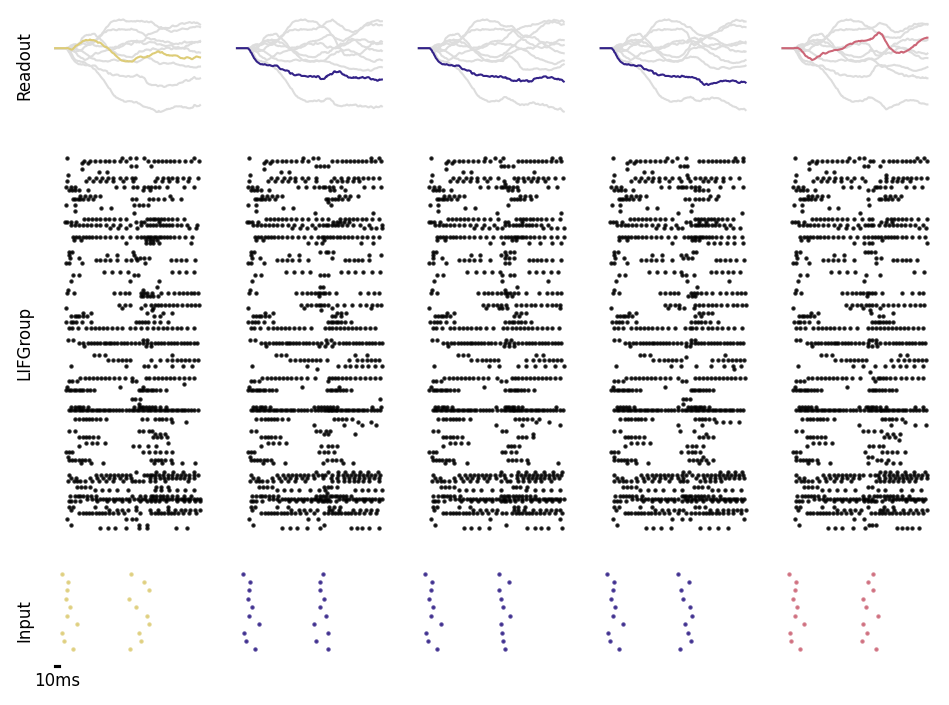

In [21]:
plt.figure(dpi=150)
plot_activity_snapshot(model, data=ds_test, point_alpha=0.8, show_predictions=False)

## Training


In [22]:
history = model.fit_validate(ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

00  loss=1.94 reg_loss=0.0507 acc=0.301 -- val_loss=1.64 val_reg_loss=0.00159 val_acc=0.361 t_iter=41.25
01  loss=1.4 reg_loss=0.00178 acc=0.443 -- val_loss=1.41 val_reg_loss=0.00168 val_acc=0.413 t_iter=43.57
02  loss=1.19 reg_loss=0.00183 acc=0.503 -- val_loss=1.28 val_reg_loss=0.00161 val_acc=0.455 t_iter=44.59
03  loss=1.06 reg_loss=0.0018 acc=0.541 -- val_loss=1.19 val_reg_loss=0.00175 val_acc=0.483 t_iter=41.49
04  loss=0.969 reg_loss=0.00194 acc=0.566 -- val_loss=1.09 val_reg_loss=0.00168 val_acc=0.509 t_iter=42.91
05  loss=0.901 reg_loss=0.00182 acc=0.588 -- val_loss=1.05 val_reg_loss=0.00164 val_acc=0.528 t_iter=43.64
06  loss=0.853 reg_loss=0.00162 acc=0.603 -- val_loss=1.02 val_reg_loss=0.00153 val_acc=0.534 t_iter=40.01
07  loss=0.818 reg_loss=0.00169 acc=0.615 -- val_loss=0.989 val_reg_loss=0.00156 val_acc=0.538 t_iter=42.65
08  loss=0.788 reg_loss=0.00156 acc=0.624 -- val_loss=0.97 val_reg_loss=0.00141 val_acc=0.552 t_iter=44.62
09  loss=0.764 reg_loss=0.00147 acc=0.631 -

#### Monitor the model again after training

In [23]:
res = model.monitor(ds_test)

In [24]:
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

In [25]:
after_pop_fr = torch.mean(res[1], dim=(2))
after_mean_pop_fr = torch.mean(after_pop_fr, dim=(0))
after_std_pop_fr = torch.std(after_pop_fr, dim=(0))

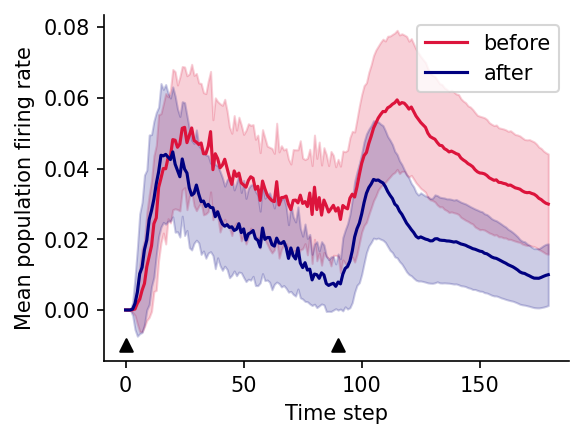

In [26]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")
plt.fill_between(
    np.arange(before_mean_pop_fr.shape[0]),
    before_mean_pop_fr - before_std_pop_fr,
    before_mean_pop_fr + before_std_pop_fr,
    color="crimson",
    alpha=0.2,
)


plt.plot(after_mean_pop_fr, color="navy", label="after")
plt.fill_between(
    np.arange(after_mean_pop_fr.shape[0]),
    after_mean_pop_fr - after_std_pop_fr,
    after_mean_pop_fr + after_std_pop_fr,
    color="navy",
    alpha=0.2,
)

plt.hlines(0, 0, after_mean_pop_fr.shape[0], linestyle="--", color="black")


plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population firing rate")
plt.legend(loc="upper right")
sns.despine()

## Test

In [27]:
scores = model.evaluate(ds_test).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  0.5447502591543727
Test acc.:  73.45 %


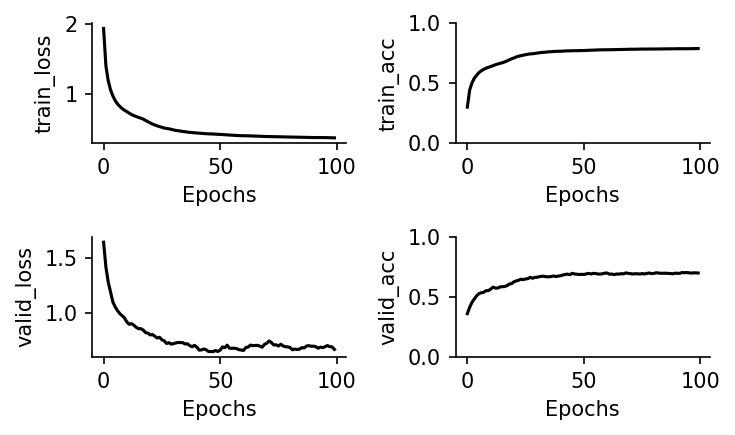

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", round(results["test_acc"] * 100, 2), "%")

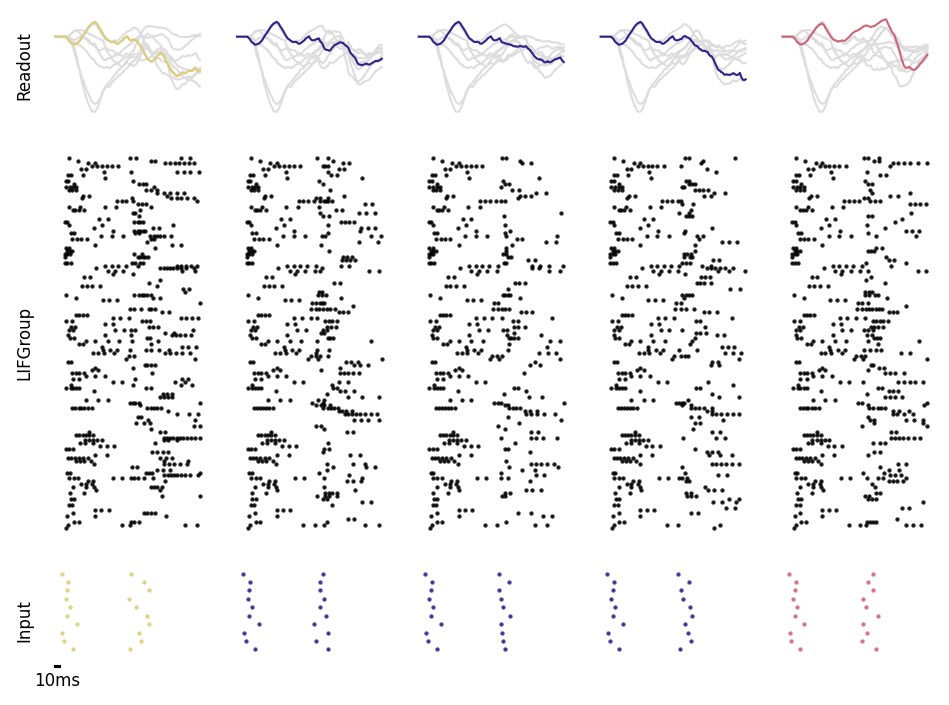

In [29]:
plt.figure(dpi=150)
plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False, nb_samples=5
)

In [30]:
after_weighted_filters = model.connections[0].get_filterbanks(T=duration)

# shape = (time, n_post, n_pre, nb_filters, kernel_size)
print(after_weighted_filters.shape)

# Sum over filter axis
after_weighted_filters_sum = after_weighted_filters.sum(axis=3)

print(after_weighted_filters_sum.shape)

(181, 128, 10, 10)
(181, 128, 10)


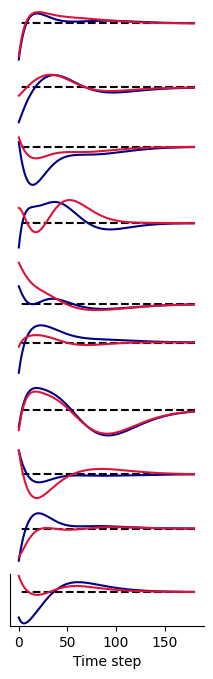

In [31]:
fig = MultiPanel(
    grid=[1] * 10, figsize=(2.5, 8), dpi=150, sharey=True, sharex=True
)  # TODO: sharex and sharey don't do anything...

for idx in range(10):
    fig.panels[idx].hlines(
        0, after_weighted_filters_sum.shape[0], 0, color="black", linestyle="--"
    )
    fig.panels[idx].plot(after_weighted_filters_sum[:, idx, 0], color="navy")
    fig.panels[idx].plot(before_weighted_filters_sum[:, idx, 0], color="crimson")

    if idx < 9:
        fig.panels[idx].axis("off")
    else:
        fig.panels[idx].set_xlabel("Time step")
        fig.panels[idx].set_yticks([])
        fig.panels[idx].spines["left"].set_visible(False)
sns.despine()